In [1]:
## sleep stage classification - 2 class - using SAX features

## feature set variables: window size (0.5, 0.2, 0.1, 0.05), alphabet size (3, 4, 5), word size (dimer, trimer)

## do 10-fold CV
## inside cross-validation, split into train, validation & test indices
## do calc on train & val to get optimal params
#     try :
#     balance with smote / balanced class weight in SVM
#     grid search + CV  -> show plots on train & val error
#     optimise prob thres

## with the optimal params, re-train using train & val, then predict on test set
## merge test set predictions from all folds into a single set - obtain esnsitivity, specificity & conf mat on this set

import pandas as pd
import numpy as np
import os
import pickle
from scipy import stats
#import itertools
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler #, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

import itertools
from sklearn.svm import SVC
from sklearn.metrics import auc,accuracy_score
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix
from sklearn.metrics import classification_report

In [2]:
###################function to plot confusion matrix#####################################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
###########################################################################################

In [3]:
## create train & test sets by ID
def CreateTrainTestID(dfull):
    
    ## select IDs
    ID = dfull['pID'].unique() # create ID list
    #np.random.seed(456)   ## select the IDs for the 2 sets
    
    '''
    msk = np.random.rand(len(ID)) < 0.8
    #print('msk')
    #print(msk)
    trainIDs = pd.DataFrame()
    testIDs = pd.DataFrame()
    trainIDs['pID'] = ID[msk]
    testIDs['pID'] = ID[~msk]
    #print(ID[msk])
    #print(ID[~msk])
    print(trainIDs['pID'].tolist())
    print(testIDs['pID'].tolist())
    Train = dfull.loc[dfull['pID'].isin(ID[msk])] # create the train-test sets
    Test = dfull.loc[dfull['pID'].isin(ID[~msk])] #'''
    
    index_list = list(range(len(ID)))
    #print('index list')
    #print(index_list)
    train_index = np.random.choice(np.array(index_list), size = round(0.8*(len(index_list))), replace=False)
    test_index = [i for i in index_list if i not in train_index]
    Train = dfull.loc[dfull['pID'].isin(ID[train_index])]
    Test = dfull.loc[dfull['pID'].isin(ID[test_index])]
    #print('train')
    print(train_index)
    #print('test')
    print(test_index)
        
    return Train, Test

def createXYsets(Train,Test):    
    ## create the sets
    X_train1 = Train.drop(['pID','day','epoch','class_label','class2'], 1).reset_index() #inplace=True, drop=True)  ## create X & y splits
    X_train1 = X_train1.drop(['index'], 1)
    X_test = Test.drop(['pID','day','epoch','class_label','class2'], 1).reset_index() #inplace=True, drop=True)
    X_test = X_test.drop(['index'],1)
    y_train1 = Train['class2'].reset_index() #inplace=True, drop=True)
    y_train1 = y_train1.drop(['index'],1)
    y_test = Test['class2'].reset_index() #inplace=True, drop=True)
    y_test = y_test.drop(['index'],1)
    print(X_train1.head(1))
    return X_train1, y_train1, X_test, y_test

In [28]:
#for i in range(10):
#    print('')    
#    print("Iteration: " + str(i))
#    
#    Train, Test = CreateTrainTestID(dfull)
    #X_train1, y_train1, X_test, y_test = createXYsets(Train,Test)
#    print('')

In [4]:
### load data ###

file_location='C:/Users/DAR9KOR/Desktop/data/HEALTHCARE/EEG/data/eeg_epochs_dec12_2018/raw_data' #C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\eeg_epochs_dec12_2018'
os.chdir('C:/Users/DAR9KOR/Desktop/data/HEALTHCARE/EEG/data/eeg_epochs_dec12_2018/raw_data') #'/home/intern_eyecare/Desktop/EEG/raw_data') #C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\eeg_epochs_dec12_2018')

# remove 2nd night of subject 13, as there was data loss - pkl file created accordingly
dfull = pickle.load(open('Frac_sax_dimer_0.1s_EEG_all_patients.pkl', 'rb'))
dfull.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,pID,day,epoch,class_label
0,0.110368,0.050167,0.016722,0.013378,0.066890,0.173913,0.060201,0.020067,0.010033,0.083612,0.163880,0.046823,0.003344,0.010033,0.063545,0.107023,400,1,s1e1,wake
1,0.090301,0.040134,0.020067,0.016722,0.050167,0.210702,0.080268,0.010033,0.020067,0.096990,0.170569,0.030100,0.006689,0.003344,0.046823,0.107023,400,1,s1e2,wake
2,0.130435,0.043478,0.003344,0.000000,0.040134,0.210702,0.053512,0.023411,0.006689,0.070234,0.167224,0.030100,0.000000,0.003344,0.050167,0.167224,400,1,s1e3,wake
3,0.123746,0.083612,0.030100,0.006689,0.050167,0.073579,0.076923,0.033445,0.050167,0.050167,0.110368,0.066890,0.020067,0.023411,0.060201,0.140468,400,1,s1e4,wake
4,0.100334,0.073579,0.050167,0.000000,0.046823,0.060201,0.096990,0.033445,0.056856,0.076923,0.133779,0.080268,0.020067,0.026756,0.063545,0.080268,400,1,s1e5,wake


In [ ]:
### check the data ###

In [6]:
# 1. look for null values
dfull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92994 entries, 0 to 92993
Data columns (total 20 columns):
0              92994 non-null float64
1              92994 non-null float64
2              92994 non-null float64
3              92994 non-null float64
4              92994 non-null float64
5              92994 non-null float64
6              92994 non-null float64
7              92994 non-null float64
8              92994 non-null float64
9              92994 non-null float64
10             92994 non-null float64
11             92994 non-null float64
12             92994 non-null float64
13             92994 non-null float64
14             92994 non-null float64
15             92994 non-null float64
pID            92994 non-null object
day            92994 non-null object
epoch          92994 non-null object
class_label    92994 non-null object
dtypes: float64(16), object(4)
memory usage: 14.2+ MB


In [7]:
dfull.isnull().sum()

0              0
1              0
2              0
3              0
4              0
5              0
6              0
7              0
8              0
9              0
10             0
11             0
12             0
13             0
14             0
15             0
pID            0
day            0
epoch          0
class_label    0
dtype: int64

In [8]:
# 2. check data distribution
dfull.groupby('class_label').size()

class_label
sleep_stage_1     2804
sleep_stage_2    17799
wake             72391
dtype: int64

In [9]:
dfull.groupby(['pID','class_label']).size()

pID  class_label  
400  sleep_stage_1     117
     sleep_stage_2     623
     wake             3882
401  sleep_stage_1     201
     sleep_stage_2    1222
     wake             3680
402  sleep_stage_1     278
     sleep_stage_2     947
     wake             3778
403  sleep_stage_1     106
     sleep_stage_2     885
     wake             3965
404  sleep_stage_1     303
     sleep_stage_2    1134
     wake             3307
405  sleep_stage_1     158
     sleep_stage_2     833
     wake             4038
406  sleep_stage_1     146
     sleep_stage_2     824
     wake             4076
407  sleep_stage_1     173
     sleep_stage_2     795
     wake             3862
408  sleep_stage_1     107
     sleep_stage_2     591
     wake             3709
409  sleep_stage_1     100
     sleep_stage_2    1073
     wake             2818
410  sleep_stage_1     182
     sleep_stage_2    1278
     wake             3679
411  sleep_stage_1      31
     sleep_stage_2     898
     wake             3943
412  slee

In [5]:
### convert from 3-class to 2-class ###
dfull['class2'] = dfull['class_label']
dfull['class2'] = [0 if x == 'wake' else 1 for x in dfull['class2']]

## convert selected columns to string/categories 
## DO NOT CONVERT 'class2' from numeric to category - this probably gives error in grid search
dfull[['class_label']] = dfull[['class_label']].astype('str')        # ,'class2'

In [14]:
'''## do multiple iterations
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for i in range(10):
    print('')    
    print("Iteration: " + str(i))
    
    Train, Test = CreateTrainTestID(dfull)
    X_train1, y_train1, X_test, y_test = createXYsets(Train,Test)
    print('')
    
    ### data scaling ###
    scaler = StandardScaler().fit(X_train1)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train1)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    
    ## model fitting
    model_svc = SVC(class_weight='balanced')  # probability=True
    model_svc.fit(X_train_scaled, y_train1)
    
    
    ## predict on test data - check metrics
    y_pred = model_svc.predict(X_test_scaled)
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_pred, target_names=class_names))
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_pred)
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_pred))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
metrics = pd.concat([sensitivity, specificity], axis=1)
metrics.columns = ['sensitivity', 'specificity']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
'''    

2019-04-05 19:26:33

Iteration: 0
['400', '401', '402', '403', '405', '406', '407', '408', '410', '411', '413', '414', '415', '417', '419']
['404', '409', '412', '416', '418']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[16076  1395]
 [  930  4461]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     17471
           1       0.76      0.83      0.79      5391

   micro avg       0.90      0.90      0.90     22862
   macro avg       0.85      0.87      0.86     22862
weighted avg       0.90      0.90      0.90     22862

accuracy: 0.8983028606421135
2019-04-05 19:29:33


Iteration: 1
['400', '401', '402', '403', '404', '405', '406', '408', '409', '411', '412', '413', '414', '415', '416', '417', '418', '419']
['407', '410']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[7038  503]
 [ 260 2168]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      7541
           1       0.81      0.89      0.85      2428

   micro avg       0.92      0.92      0.92      9969
   macro avg       0.89      0.91      0.90      9969
weighted avg       0.93      0.92      0.92      9969

accuracy: 0.9234627344768783
2019-04-05 19:33:51


Iteration: 2
['400', '403', '404', '405', '406', '407', '408', '409', '411', '413', '414', '415', '416', '417', '418', '419']
['401', '402', '410', '412']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[13613  1252]
 [  569  4458]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     14865
           1       0.78      0.89      0.83      5027

   micro avg       0.91      0.91      0.91     19892
   macro avg       0.87      0.90      0.88     19892
weighted avg       0.91      0.91      0.91     19892

accuracy: 0.9084556605670622
2019-04-05 19:37:20


Iteration: 3
['400', '403', '404', '405', '407', '408', '409', '410', '411', '412', '413', '414', '415', '417', '419']
['401', '402', '406', '416', '418']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[18193   959]
 [ 1010  4470]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     19152
           1       0.82      0.82      0.82      5480

   micro avg       0.92      0.92      0.92     24632
   macro avg       0.89      0.88      0.88     24632
weighted avg       0.92      0.92      0.92     24632

accuracy: 0.9200633322507308
2019-04-05 19:40:29


Iteration: 4
['400', '401', '402', '404', '406', '407', '408', '410', '412', '413', '414', '415', '417', '418']
['403', '405', '409', '411', '416', '419']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[18034  3483]
 [ 1096  5449]]
              precision    recall  f1-score   support

           0       0.94      0.84      0.89     21517
           1       0.61      0.83      0.70      6545

   micro avg       0.84      0.84      0.84     28062
   macro avg       0.78      0.84      0.80     28062
weighted avg       0.87      0.84      0.84     28062

accuracy: 0.8368256004561329
2019-04-05 19:43:10


Iteration: 5
['401', '402', '403', '405', '406', '408', '409', '410', '411', '412', '414', '415', '416', '418', '419']
['400', '404', '407', '413', '417']
         0         1         2         3         4         5         6    7   \
0  0.073579  0.020067  0.010033  0.020067  0.033445  0.301003  0.073579  0.0   

         8         9         10        11        12        13        14  \
0  0.010033  0.080268  0.197324  0.026756  0.006689  0.006689  0.036789   

         15  
0  0.103679  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[12478  4065]
 [  351  4428]]
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     16543
           1       0.52      0.93      0.67      4779

   micro avg       0.79      0.79      0.79     21322
   macro avg       0.75      0.84      0.76     21322
weighted avg       0.87      0.79      0.81     21322

accuracy: 0.792889972798049
2019-04-05 19:46:05


Iteration: 6
['400', '401', '403', '404', '405', '410', '411', '413', '414', '415', '417', '418', '419']
['402', '406', '407', '408', '409', '412', '416']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[23820  1770]
 [ 1531  5426]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     25590
           1       0.75      0.78      0.77      6957

   micro avg       0.90      0.90      0.90     32547
   macro avg       0.85      0.86      0.85     32547
weighted avg       0.90      0.90      0.90     32547

accuracy: 0.8985774418533198
2019-04-05 19:55:56


Iteration: 7
['400', '402', '403', '404', '405', '407', '408', '409', '410', '411', '412', '413', '415', '417', '418', '419']
['401', '406', '414', '416']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[13643  1674]
 [  484  3759]]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     15317
           1       0.69      0.89      0.78      4243

   micro avg       0.89      0.89      0.89     19560
   macro avg       0.83      0.89      0.85     19560
weighted avg       0.91      0.89      0.89     19560

accuracy: 0.8896728016359918
2019-04-05 20:00:36


Iteration: 8
['400', '401', '402', '404', '406', '407', '408', '409', '410', '411', '413', '414', '415', '416', '417', '418', '419']
['403', '405', '412']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[10037  1694]
 [  135  2766]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     11731
           1       0.62      0.95      0.75      2901

   micro avg       0.88      0.88      0.88     14632
   macro avg       0.80      0.90      0.83     14632
weighted avg       0.91      0.88      0.88     14632

accuracy: 0.875
2019-04-05 20:04:55


Iteration: 9
['400', '401', '403', '404', '406', '407', '408', '409', '410', '411', '413', '414', '415', '417', '418', '419']
['402', '405', '412', '416']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[13775  1388]
 [  732  3407]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     15163
           1       0.71      0.82      0.76      4139

   micro avg       0.89      0.89      0.89     19302
   macro avg       0.83      0.87      0.85     19302
weighted avg       0.90      0.89      0.89     19302

accuracy: 0.890166822090975
2019-04-05 20:08:33

   sensitivity  specificity
0     0.827490     0.920153
1     0.892916     0.933298
2     0.886811     0.915775
3     0.815693     0.949927
4     0.832544     0.838128
5     0.926554     0.754277
6     0.779934     0.930832
7     0.885930     0.890710
8     0.953464     0.855596
9     0.823146     0.908461
avg sensitivity: 0.862448214705948
avg specificity: 0.8897158000055102


2019-04-05 23:32:00

Iteration: 0
[ 9  1 10  3  8  5 16  7  4 11 15 12 19 17  2 14]
[0, 6, 13, 18]
         0         1         2         3         4         5         6    7   \
0  0.073579  0.020067  0.010033  0.020067  0.033445  0.301003  0.073579  0.0   

         8         9         10        11        12        13        14  \
0  0.010033  0.080268  0.197324  0.026756  0.006689  0.006689  0.036789   

         15  
0  0.103679  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.9  0.1 ]
 [0.09 0.91]]


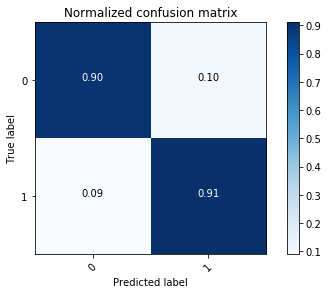

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     13898
           1       0.67      0.91      0.77      3122

   micro avg       0.90      0.90      0.90     17020
   macro avg       0.82      0.90      0.85     17020
weighted avg       0.92      0.90      0.91     17020

2019-04-05 23:38:10


Iteration: 1
[19 14 13  4  1  0 12  9 16  2 11  8 17 10  7 18]
[3, 5, 6, 15]
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.86 0.14]
 [0.06 0.94]]


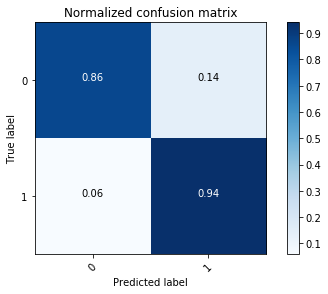

              precision    recall  f1-score   support

           0       0.98      0.86      0.92     15819
           1       0.62      0.94      0.75      3832

   micro avg       0.87      0.87      0.87     19651
   macro avg       0.80      0.90      0.83     19651
weighted avg       0.91      0.87      0.88     19651

2019-04-05 23:44:07


Iteration: 2
[ 0 13  9 14 16  4 10  6 17 18  2  7 12  8 11  1]
[3, 5, 15, 19]
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.78 0.22]
 [0.05 0.95]]


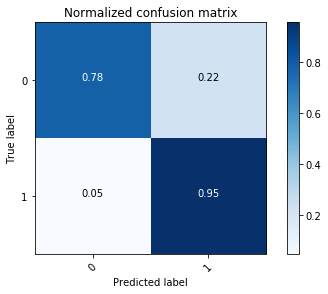

              precision    recall  f1-score   support

           0       0.98      0.78      0.87     14877
           1       0.56      0.95      0.71      4319

   micro avg       0.82      0.82      0.82     19196
   macro avg       0.77      0.87      0.79     19196
weighted avg       0.89      0.82      0.83     19196

2019-04-05 23:49:43


Iteration: 3
[ 0  1 15 19  7 11  5  6 12 16 17 10  3  4  9 18]
[2, 8, 13, 14]
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.86 0.14]
 [0.11 0.89]]


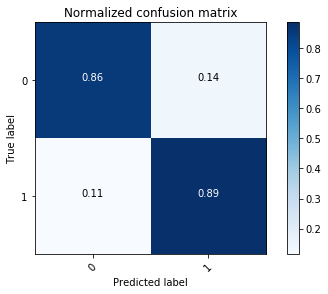

              precision    recall  f1-score   support

           0       0.97      0.86      0.91     13370
           1       0.61      0.89      0.72      3323

   micro avg       0.86      0.86      0.86     16693
   macro avg       0.79      0.87      0.81     16693
weighted avg       0.90      0.86      0.87     16693

2019-04-05 23:55:36


Iteration: 4
[ 5 19 16  9 17 13  7 10  4  6  1 11  3  8  0 14]
[2, 12, 15, 18]
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.9  0.1 ]
 [0.14 0.86]]


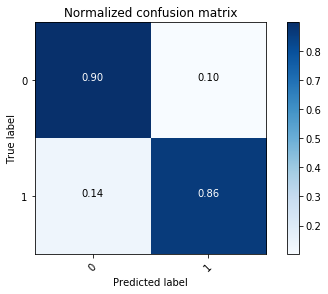

              precision    recall  f1-score   support

           0       0.96      0.90      0.93     15245
           1       0.68      0.86      0.76      3882

   micro avg       0.89      0.89      0.89     19127
   macro avg       0.82      0.88      0.85     19127
weighted avg       0.91      0.89      0.90     19127

2019-04-06 00:01:19


Iteration: 5
[ 3  5  2 15 10  7 17  4  1  6 13 16 11  8 14 19]
[0, 9, 12, 18]
         0         1         2         3         4         5         6    7   \
0  0.073579  0.020067  0.010033  0.020067  0.033445  0.301003  0.073579  0.0   

         8         9         10        11        12        13        14  \
0  0.010033  0.080268  0.197324  0.026756  0.006689  0.006689  0.036789   

         15  
0  0.103679  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.88 0.12]
 [0.11 0.89]]


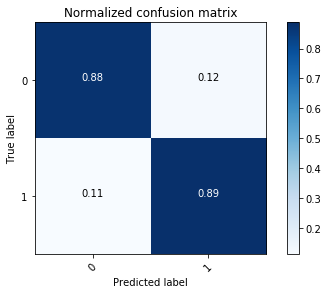

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     14427
           1       0.65      0.89      0.75      3690

   micro avg       0.88      0.88      0.88     18117
   macro avg       0.81      0.88      0.83     18117
weighted avg       0.90      0.88      0.89     18117

2019-04-06 00:07:13


Iteration: 6
[11  7 16 10  0  3 12 19  6  5 15 17 14 18  1  9]
[2, 4, 8, 13]
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.9  0.1 ]
 [0.14 0.86]]


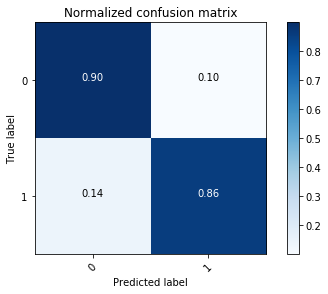

              precision    recall  f1-score   support

           0       0.95      0.90      0.93     12735
           1       0.72      0.86      0.78      3914

   micro avg       0.89      0.89      0.89     16649
   macro avg       0.84      0.88      0.85     16649
weighted avg       0.90      0.89      0.89     16649

2019-04-06 00:13:02


Iteration: 7
[19  5  2 14  6  4 12 17  0 11 18 13  8 16  3 10]
[1, 7, 9, 15]
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.89 0.11]
 [0.12 0.88]]


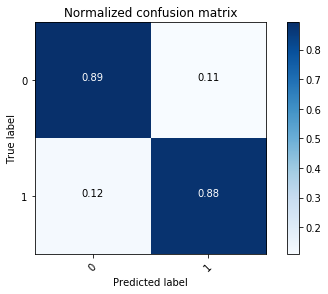

              precision    recall  f1-score   support

           0       0.96      0.89      0.92     14100
           1       0.72      0.88      0.79      4444

   micro avg       0.89      0.89      0.89     18544
   macro avg       0.84      0.89      0.86     18544
weighted avg       0.90      0.89      0.89     18544

2019-04-06 00:18:49


Iteration: 8
[ 6  7 12 18  0  5 17  1  4  9  2 16 11 15 13  3]
[8, 10, 14, 19]
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.79 0.21]
 [0.05 0.95]]


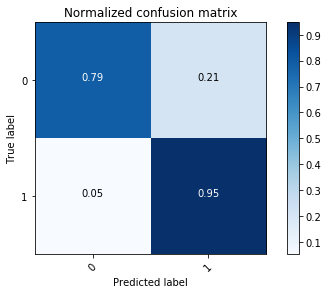

              precision    recall  f1-score   support

           0       0.98      0.79      0.87     14464
           1       0.58      0.95      0.72      4461

   micro avg       0.83      0.83      0.83     18925
   macro avg       0.78      0.87      0.80     18925
weighted avg       0.89      0.83      0.84     18925

2019-04-06 00:24:25


Iteration: 9
[13 10 11 16  7  9 14  1  5 17  6  0  2  8  4 12]
[3, 15, 18, 19]
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.82 0.18]
 [0.06 0.94]]


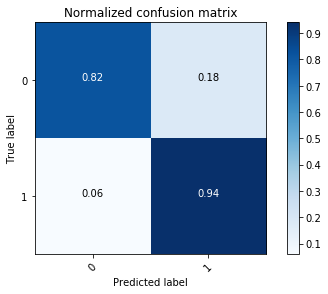

              precision    recall  f1-score   support

           0       0.98      0.82      0.89     14838
           1       0.59      0.94      0.73      4186

   micro avg       0.85      0.85      0.85     19024
   macro avg       0.79      0.88      0.81     19024
weighted avg       0.89      0.85      0.86     19024

2019-04-06 00:30:04

   sensitivity  specificity  accuracy
0     0.910314     0.897251  0.899647
1     0.941023     0.858398  0.874510
2     0.954851     0.781139  0.820223
3     0.885044     0.856470  0.862158
4     0.863215     0.898459  0.891305
5     0.887534     0.876274  0.878567
6     0.856924     0.898861  0.889002
7     0.880738     0.891631  0.889021
8     0.947770     0.788440  0.825997
9     0.940755     0.818304  0.845248
avg sensitivity: 0.9068166266584958
avg specificity: 0.8565227305620622
avg accuracy: 0.8675679522122344


In [29]:
## do multiple iterations
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for i in range(10):
    print('')    
    print("Iteration: " + str(i))
    
    Train, Test = CreateTrainTestID(dfull)
    X_train1, y_train1, X_test, y_test = createXYsets(Train,Test)
    print('')
    
    ### data scaling ###
    scaler = StandardScaler().fit(X_train1)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train1)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    
    ## model fitting
    model_svc = SVC(class_weight='balanced')  # probability=True
    model_svc.fit(X_train_scaled, y_train1)
    
    
    ## predict on test data - check metrics
    y_pred = model_svc.predict(X_test_scaled)
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_pred, target_names=class_names))
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_pred)
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_pred))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    

2019-04-06 10:51:59
TRAIN: ['401' '402' '403' '404' '405' '406' '407' '408' '409' '410' '411' '412'
 '413' '414' '415' '416' '418' '419'] TEST: ['400' '417']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.57 0.43]
 [0.02 0.98]]


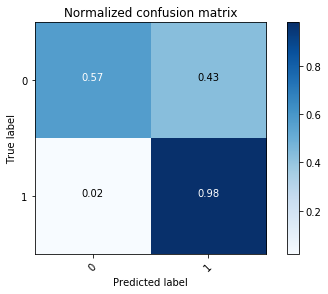

              precision    recall  f1-score   support

           0       0.99      0.57      0.72      7433
           1       0.36      0.98      0.52      1820

   micro avg       0.65      0.65      0.65      9253
   macro avg       0.67      0.77      0.62      9253
weighted avg       0.87      0.65      0.68      9253

2019-04-06 10:55:57

TRAIN: ['400' '402' '403' '404' '405' '406' '407' '408' '409' '410' '411' '412'
 '413' '414' '416' '417' '418' '419'] TEST: ['401' '415']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.88 0.12]
 [0.08 0.92]]


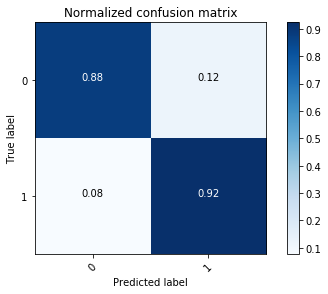

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      7420
           1       0.70      0.92      0.80      2303

   micro avg       0.89      0.89      0.89      9723
   macro avg       0.84      0.90      0.86      9723
weighted avg       0.91      0.89      0.89      9723

2019-04-06 11:00:34

TRAIN: ['400' '401' '402' '403' '404' '406' '407' '409' '410' '411' '412' '413'
 '414' '415' '416' '417' '418' '419'] TEST: ['405' '408']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.86 0.14]
 [0.07 0.93]]


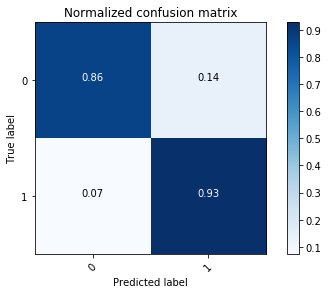

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7747
           1       0.60      0.93      0.72      1689

   micro avg       0.87      0.87      0.87      9436
   macro avg       0.79      0.89      0.82      9436
weighted avg       0.91      0.87      0.88      9436

2019-04-06 11:05:02

TRAIN: ['400' '401' '402' '404' '405' '406' '407' '408' '409' '410' '412' '413'
 '414' '415' '416' '417' '418' '419'] TEST: ['403' '411']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.82 0.18]
 [0.25 0.75]]


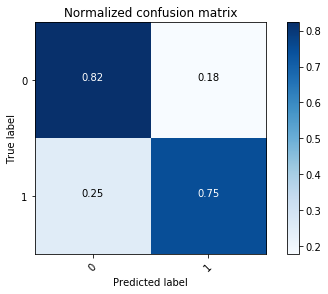

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      7908
           1       0.51      0.75      0.60      1920

   micro avg       0.81      0.81      0.81      9828
   macro avg       0.72      0.79      0.74      9828
weighted avg       0.85      0.81      0.82      9828

2019-04-06 11:09:29

TRAIN: ['400' '401' '402' '403' '404' '405' '406' '407' '408' '409' '410' '411'
 '412' '413' '414' '415' '417' '419'] TEST: ['416' '418']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.96 0.04]
 [0.24 0.76]]


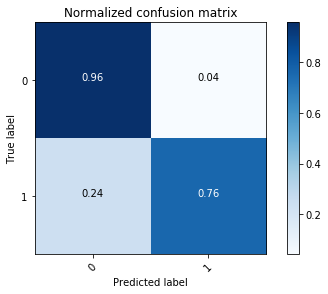

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7618
           1       0.81      0.76      0.79      1862

   micro avg       0.92      0.92      0.92      9480
   macro avg       0.88      0.86      0.87      9480
weighted avg       0.92      0.92      0.92      9480

2019-04-06 11:13:55

TRAIN: ['400' '401' '403' '404' '405' '406' '407' '408' '409' '410' '411' '412'
 '414' '415' '416' '417' '418' '419'] TEST: ['402' '413']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.92 0.08]
 [0.17 0.83]]


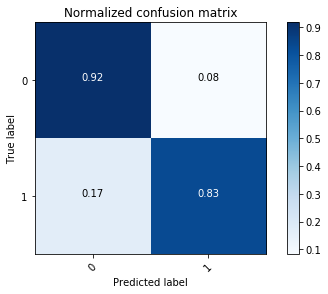

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      5719
           1       0.76      0.83      0.79      1779

   micro avg       0.90      0.90      0.90      7498
   macro avg       0.85      0.87      0.86      7498
weighted avg       0.90      0.90      0.90      7498

2019-04-06 11:18:23

TRAIN: ['400' '401' '402' '403' '404' '405' '406' '407' '408' '410' '411' '412'
 '413' '414' '415' '416' '417' '418'] TEST: ['409' '419']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.76 0.24]
 [0.09 0.91]]


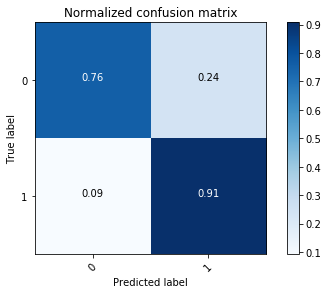

              precision    recall  f1-score   support

           0       0.95      0.76      0.84      5952
           1       0.63      0.91      0.74      2630

   micro avg       0.81      0.81      0.81      8582
   macro avg       0.79      0.83      0.79      8582
weighted avg       0.85      0.81      0.81      8582

2019-04-06 11:22:42

TRAIN: ['400' '401' '402' '403' '405' '406' '407' '408' '409' '410' '411' '413'
 '414' '415' '416' '417' '418' '419'] TEST: ['404' '412']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.87 0.13]
 [0.09 0.91]]


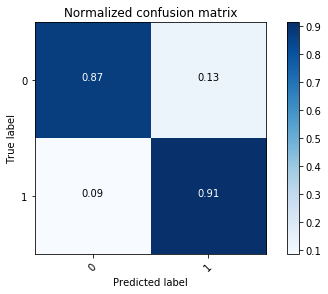

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      7035
           1       0.70      0.91      0.80      2356

   micro avg       0.88      0.88      0.88      9391
   macro avg       0.84      0.89      0.86      9391
weighted avg       0.90      0.88      0.89      9391

2019-04-06 11:27:10

TRAIN: ['400' '401' '402' '403' '404' '405' '406' '408' '409' '411' '412' '413'
 '414' '415' '416' '417' '418' '419'] TEST: ['407' '410']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.93 0.07]
 [0.11 0.89]]


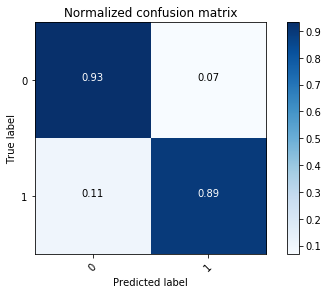

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      7541
           1       0.81      0.89      0.85      2428

   micro avg       0.92      0.92      0.92      9969
   macro avg       0.89      0.91      0.90      9969
weighted avg       0.93      0.92      0.92      9969

2019-04-06 14:25:58

TRAIN: ['400' '401' '402' '403' '404' '405' '407' '408' '409' '410' '411' '412'
 '413' '415' '416' '417' '418' '419'] TEST: ['406' '414']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.84 0.16]
 [0.05 0.95]]


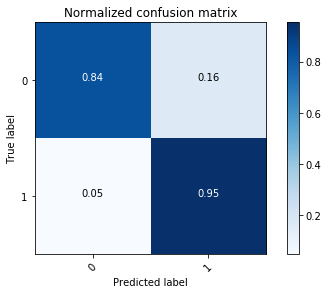

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      8018
           1       0.57      0.95      0.72      1816

   micro avg       0.86      0.86      0.86      9834
   macro avg       0.78      0.90      0.81      9834
weighted avg       0.91      0.86      0.87      9834

2019-04-06 14:33:22

   sensitivity  specificity  accuracy
0     0.979670     0.569487  0.650168
1     0.923144     0.878167  0.888820
2     0.927176     0.862527  0.874099
3     0.747396     0.822838  0.808099
4     0.762084     0.956944  0.918671
5     0.831928     0.917818  0.897439
6     0.907605     0.760921  0.805873
7     0.913837     0.871215  0.881908
8     0.894975     0.931972  0.922961
9     0.953194     0.839486  0.860484
avg sensitivity: 0.88410082581447
avg specificity: 0.8411375573642488
avg accuracy: 0.8508522723644031


In [7]:
from sklearn.model_selection import KFold, cross_validate, cross_val_score
pid_tr = dfull['pID'].unique() 
K = 10
kf = KFold(n_splits=K,shuffle=True,random_state=42)
dn = dfull
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))


for train_index, test_index in kf.split(pid_tr):
    print("TRAIN:", pid_tr[train_index], "TEST:", pid_tr[test_index])
    
    df_test = pd.DataFrame()
    df_train = pd.DataFrame()
    for pid in train_index:
        df_tr = dn[(dn['pID']==pid_tr[pid])]
        df_train = pd.concat([df_train,df_tr])
    for pid in test_index:
        df_ts = dn[(dn['pID']==pid_tr[pid])]
        df_test = pd.concat([df_test,df_ts], ignore_index = True)
    
    X_train = df_train.drop([   'pID',  'epoch','class_label', 'class2'],1).reset_index()
    X_train = X_train.drop(['index'],1)
        
    y_train = df_train['class2'].reset_index()
    y_train = y_train.drop(['index'],1)
    
    X_test = df_test.drop([   'pID',  'epoch','class_label', 'class2'],1).reset_index()
    X_test = X_test.drop(['index'],1)
    
    y_test = df_test[['class2']].reset_index()
    y_test = y_test.drop(['index'],1)
    
    ### data scaling ###
    scaler = StandardScaler().fit(X_train)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    
    ## model fitting
    model_svc = SVC(class_weight='balanced')  # probability=True
    model_svc.fit(X_train_scaled, y_train)
    
    
    ## predict on test data - check metrics
    y_pred = model_svc.predict(X_test_scaled)
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_pred, target_names=class_names))
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_pred)
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_pred))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    

In [ ]:
############# TRY PARAMATER OPTIMISATIONS ####################

## do 5-fold CV
## inside cross-validation, split into train, validation & test indices
## do calc on train & val to get optimal params
#     try :
#     balance with smote / balanced class weight in SVM
#     grid search + CV  -> show plots on train & val error
#     optimise prob thres


In [8]:
#'''
# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

from sklearn.metrics import make_scorer,recall_score,accuracy_score,precision_score   #roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold   # train_test_split,

clf = SVC(class_weight='balanced') #n_jobs=-1)  # this runs the computation in parallel

param_grid = [
  #{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50], 'gamma': [0.01, 0.05, 0.1, 0.5], 'kernel': ['rbf']},
 ]


scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}



def grid_search_wrapper(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train.values)  # X_train.values

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)
    
    results = pd.DataFrame(grid_search_clf.cv_results_)
    results = results[['param_C','param_gamma','mean_train_recall_score','mean_test_recall_score','mean_train_accuracy_score','mean_test_accuracy_score','mean_train_precision_score','mean_test_precision_score']] 
   
    
    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    # confusion matrix on the test data.
    print('\nConfusion matrix of SVM optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search, results
#'''

In [9]:
## check a single iteration of train-test; the train is further split into train_val 10 times

Train, Test = CreateTrainTestID(dfull)
X_train, y_train, X_test, y_test = createXYsets(Train,Test)
print('')
    
### data scaling ###
scaler = StandardScaler().fit(X_train)  # StandardScaler();  MinMaxScaler()
X_train_scaled = scaler.transform(X_train)    # fit_transform(X_train1)
X_test_scaled = scaler.transform(X_test)

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
print('')

### run grid search ###
grid_search_clf, results = grid_search_wrapper(refit_score='recall_score')

print('')
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

[ 7 14 10  8  9  0 15 11  5 19  3  1 12  2 13  4]
[6, 16, 17, 18]
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  

2019-04-06 15:57:26



KeyboardInterrupt: 

In [ ]:
## sort by different metrics ##
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results

In [ ]:
## sort by different metrics ##
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results

In [ ]:
## sort by different metrics ##
results = results.sort_values(by='mean_train_accuracy_score', ascending=False)

# dataframe & plots
fig, ax2 = plt.subplots(1, 1)
ax2.hold(True)
ax2.plot(results['mean_train_accuracy_score'],label='Traning set')
ax2.plot(results['mean_test_accuracy_score'],label='Validation set')
#ax2.set_title("Training and Validation precision")
ax2.set_ylabel("accuracy")
ax2.set_xlabel("Iterations")
ax2.set_xlim([0,20])
ax2.legend(fancybox=True)